In [293]:
import re
import dill
import nltk
import torch
import pymorphy3
import pandas as pd
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


In [370]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 0)
df = pd.read_csv('/Users/user/Downloads/bads.csv', sep=';')
df['Worklog Date'] = pd.to_datetime(df['Worklog Date'])
df['Detailed_Description'] = df['Detailed_Description'].apply(lambda x: x + '. ')

bads = (
    df
    .groupby(['Incident Title', 'Incident Notes', 'Incident_Number'])
    .agg(
        text=('Detailed_Description', 'sum'),
        Log_Count=('Worklog Date', 'count'),
        Avg_Log_Interval=('Worklog Date', lambda x: x.sort_values().diff().dt.total_seconds().mean() / 3600),
        Max_Log_Interval=('Worklog Date', lambda x: x.sort_values().diff().dt.total_seconds().max() / 3600),
        Status_Change_Count=('Work_Log_Type.1', lambda x: (x == 21003).sum()),
        Reassignments=('Work_Log_Type.1', lambda x: (x == 20000).sum()),
        Customer_Communications=('Work_Log_Type.1', lambda x: (x == 2000).sum()),
        Was_Reopen=('Work_Log_Type.1', lambda x: int((x == 21005).any())),
        Wrong_Assignment=(
            'Detailed_Description',
            lambda s: int(
                s.astype(str)
                 .str.contains('Wrong Assignment', case=False, na=False)
                 .any()
            )
        ),
        # время жизни тикета
        First_Date=('Worklog Date', 'min'),
        Last_Date=('Worklog Date', 'max')
    )
    .reset_index()
)

# разница в часах
bads['Lifetime_hours'] = (bads['Last_Date'] - bads['First_Date']).dt.total_seconds() / 3600

# текстовое поле
bads['text'] = bads.apply(
    lambda x: 'Title ' + str(x['Incident Title']) +
              '. Notes ' + str(x['Incident Notes']) +
              '. Worklog ' + str(x['text']),
    axis=1
)

# чистим ненужное
bads.drop(['Incident Title', 'Incident Notes', 'First_Date', 'Last_Date', 'Was_Reopen', 'Wrong_Assignment'], axis=1, inplace=True)

def preprocess_for_bert(text):
    text = str(text)
    text = re.sub(r'https?://\S+', ' <URL> ', text)
    text = re.sub(r'\S+@\S+', ' <EMAIL> ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

bads['text'] = bads.text.apply(preprocess_for_bert)

bads['labels'] = 1
bads.describe()

,Log_Count,Avg_Log_Interval,Max_Log_Interval,Status_Change_Count,Reassignments,Customer_Communications,Lifetime_hours,labels
count,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.000000,281.0
mean,37.921708,6.202146,100.362205,9.864769,7.676157,2.395018,278.573719,1.0
std,29.152326,9.114791,151.470645,8.237731,5.998670,2.298410,476.857564,0.0
min,7.000000,0.032361,0.194167,2.000000,1.000000,0.000000,0.194167,1.0
25%,19.000000,1.340694,16.854167,4.000000,4.000000,1.000000,25.885833,1.0
50%,29.000000,3.915873,67.792500,8.000000,6.000000,2.000000,121.910556,1.0
75%,45.000000,7.574019,111.313611,12.000000,9.000000,3.000000,288.538889,1.0
max,203.000000,89.930814,1491.057778,51.000000,52.000000,17.000000,3214.225278,1.0


In [371]:
bads_val = bads.sort_values('Incident_Number', ascending=False).iloc[:int(bads.shape[0]*0.2)]
bads = bads.sort_values('Incident_Number', ascending=False).iloc[int(bads.shape[0]*0.2):]

In [ ]:
dfgg = pd.read_csv('/Users/user/Downloads/good.csv', sep=';')

dfgg['Worklog Date'] = pd.to_datetime(dfgg['Worklog Date'])
dfgg['Detailed_Description'] = dfgg['Detailed_Description'].apply(lambda x: x + '. ')

dfgg = (
    dfgg
    .groupby(['Incident Title', 'Incident Notes', 'Incident_Number'])
    .agg(
        text=('Detailed_Description', 'sum'),
        Log_Count=('Worklog Date', 'count'),
        Avg_Log_Interval=('Worklog Date', lambda x: x.sort_values().diff().dt.total_seconds().mean() / 3600),
        Max_Log_Interval=('Worklog Date', lambda x: x.sort_values().diff().dt.total_seconds().max() / 3600),
        Status_Change_Count=('Work_Log_Type.1', lambda x: (x == 21003).sum()),
        Reassignments=('Work_Log_Type.1', lambda x: (x == 20000).sum()),
        Customer_Communications=('Work_Log_Type.1', lambda x: (x == 2000).sum()),
        Was_Reopen=('Work_Log_Type.1', lambda x: int((x == 21005).any())),
        Wrong_Assignment=(
            'Detailed_Description',
            lambda s: int(
                s.astype(str)
                 .str.contains('Wrong Assignment', case=False, na=False)
                 .any()
            )
        ),
        # время жизни тикета
        First_Date=('Worklog Date', 'min'),
        Last_Date=('Worklog Date', 'max')
    )
    .reset_index()
)

# разница в часах
dfgg['Lifetime_hours'] = (dfgg['Last_Date'] - dfgg['First_Date']).dt.total_seconds() / 3600

# текстовое поле
dfgg['text'] = dfgg.apply(
    lambda x: 'Title ' + str(x['Incident Title']) +
              '. Notes ' + str(x['Incident Notes']) +
              '. Worklog ' + str(x['text']),
    axis=1
)

# чистим ненужное
dfgg.drop(['Incident Title', 'Incident Notes', 'First_Date', 'Last_Date', 'Was_Reopen', 'Wrong_Assignment'], axis=1, inplace=True)

dfgg['labels'] = 0
dfgg.describe()

,Log_Count,Avg_Log_Interval,Max_Log_Interval,Status_Change_Count,Reassignments,Customer_Communications,Lifetime_hours,labels
count,244526.000000,244518.000000,244518.000000,244526.000000,244526.000000,244526.000000,244526.000000,244526.0
mean,16.210501,5.074547,55.796734,4.440448,2.245074,1.363180,110.503639,0.0
std,15.555585,30.871835,261.892410,3.923723,2.716171,1.390614,437.960945,0.0
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
25%,7.000000,0.058148,0.303889,2.000000,1.000000,1.000000,0.409444,0.0
50%,11.000000,0.441896,3.072639,3.000000,1.000000,1.000000,4.470139,0.0
75%,20.000000,4.362183,64.080556,6.000000,3.000000,2.000000,84.164236,0.0
max,2122.000000,4441.572778,14898.770000,294.000000,84.000000,39.000000,16729.386111,0.0


In [321]:
#в регионах около 25000 заявок из 244000
dfgg = dfgg[~(dfgg['text'].str.contains('@apac.kaspersky.com') | dfgg['text'].str.contains('@eu.kaspersky.com') | dfgg['text'].str.contains('@us.kaspersky.com'))]
dfgg['text'] = dfgg.text.apply(preprocess_for_bert)
good = dfgg[dfgg['text'].str.len()>2000].sample(2810).reset_index(drop=True)
not_in_good = dfgg[~dfgg.index.isin(good.index)]
good_val = good.sort_values('Incident_Number', ascending=False).iloc[:int(good.shape[0]*0.2)]
good = good.sort_values('Incident_Number', ascending=False).iloc[int(good.shape[0]*0.2):]
not_in_good_val = not_in_good.sort_values('Incident_Number', ascending=False).iloc[:int(not_in_good.shape[0]*0.2)]

In [322]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, fbeta_score,confusion_matrix, roc_auc_score
X = pd.concat([good, bads]).drop(['Incident_Number', 'text'], axis=1)
y = X['labels']
X = X.drop(['labels'], axis=1)
xtr,xte,ytr,yte = train_test_split(X, y, test_size=.1, shuffle=True, stratify=y, random_state=42)
import catboost
boost = catboost.CatBoostClassifier(class_weights={0:1, 1:10})
boost.fit(xtr,ytr)
print(fbeta_score(yte, boost.predict(xte), beta=2, average='macro'))
confusion_matrix(yte, boost.predict(xte))

Learning rate set to 0.014637
0:	learn: 0.6855991	total: 890us	remaining: 890ms
1:	learn: 0.6788569	total: 1.94ms	remaining: 970ms
2:	learn: 0.6740454	total: 2.84ms	remaining: 943ms
3:	learn: 0.6679907	total: 3.86ms	remaining: 962ms
4:	learn: 0.6626507	total: 4.74ms	remaining: 943ms
5:	learn: 0.6566323	total: 5.69ms	remaining: 943ms
6:	learn: 0.6507671	total: 6.58ms	remaining: 933ms
7:	learn: 0.6470567	total: 7.58ms	remaining: 940ms
8:	learn: 0.6425312	total: 9.13ms	remaining: 1s
9:	learn: 0.6386214	total: 9.96ms	remaining: 986ms
10:	learn: 0.6354863	total: 10.8ms	remaining: 974ms
11:	learn: 0.6299084	total: 11.8ms	remaining: 970ms
12:	learn: 0.6263379	total: 12.6ms	remaining: 958ms
13:	learn: 0.6205092	total: 13.6ms	remaining: 955ms
14:	learn: 0.6179019	total: 16.9ms	remaining: 1.11s
15:	learn: 0.6150612	total: 19.7ms	remaining: 1.21s
16:	learn: 0.6097799	total: 22ms	remaining: 1.27s
17:	learn: 0.6053224	total: 28.2ms	remaining: 1.54s
18:	learn: 0.6026717	total: 30.3ms	remaining: 1.56

array([[189,  36],
       [  9,  19]])

In [323]:
#boost.save_model("catboost_final_light.cbm")
print(f1_score(yte, boost.predict(xte)))
roc_auc_score(yte, boost.predict_proba(xte)[:,1])

0.4578313253012048


0.8666666666666667

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)
from datasets import Dataset

formlm = not_in_good[(not_in_good['text'].str.len()>1000) & (not_in_good['text'].str.len()<7000)].sample(50000).reset_index(drop=True)

model_name = "sberbank-ai/ruRoberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name)

texts = formlm['text'].tolist()
dataset = Dataset.from_dict({"text": texts})

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
)

args = TrainingArguments(
    output_dir="./ruroberta_tickets_mlm_50000",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=100,
    save_steps=1000,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized,
    data_collator=data_collator,
)

# trainer.train()

# Сохраняем чекпоинт
# trainer.save_model("./ruroberta_tickets_mlm")
# tokenizer.save_pretrained("./ruroberta_tickets_mlm")

/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [325]:
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
model_name = "./ruroberta_tickets_mlm_50000"
tokenizer = AutoTokenizer.from_pretrained(model_name, legacy_format=True, use_fast=False)
model = AutoModel.from_pretrained(model_name)
texts = pd.concat([good, bads])['text'].tolist()  # одна строка на тикет
dataset = Dataset.from_dict({"text": texts})

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

tokenized = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
tokenized.set_format('torch', columns=["input_ids", "attention_mask"])

loader = DataLoader(tokenized, batch_size=16, shuffle=False)
model.eval()
model.to("mps")

all_cls = []

with torch.no_grad():
    for batch in loader:
        batch = {k: v.to("mps") for k, v in batch.items()}

        out = model(**batch)
        cls = out.last_hidden_state[:, 0, :]
        all_cls.append(cls.cpu())
all_cls = torch.cat(all_cls, dim=0)

import numpy as np
#CatBoost + CLS по текстовым эмбеддингам
X_text = all_cls.numpy()
X_tab  = X.values
X_full = np.concatenate([X_text, X_tab], axis=1)
xtr1,xte1,ytr1,yte1 = train_test_split(X_full, y, test_size=.1, shuffle=True, random_state=42)
cboost = catboost.CatBoostClassifier(class_weights={0:1, 1:10})
cboost.fit(xtr1,ytr1)
print(fbeta_score(yte1, cboost.predict(xte1), beta=2, average='macro'))
confusion_matrix(yte1, cboost.predict(xte1))

Some weights of RobertaModel were not initialized from the model checkpoint at ./ruroberta_tickets_mlm_50000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2529 [00:00<?, ? examples/s]

Learning rate set to 0.014637
0:	learn: 0.6877764	total: 28.7ms	remaining: 28.7s
1:	learn: 0.6807106	total: 49.7ms	remaining: 24.8s
2:	learn: 0.6741192	total: 70.1ms	remaining: 23.3s
3:	learn: 0.6679164	total: 90.3ms	remaining: 22.5s
4:	learn: 0.6622342	total: 110ms	remaining: 22s
5:	learn: 0.6576922	total: 130ms	remaining: 21.6s
6:	learn: 0.6520408	total: 150ms	remaining: 21.3s
7:	learn: 0.6454707	total: 173ms	remaining: 21.4s
8:	learn: 0.6403029	total: 194ms	remaining: 21.3s
9:	learn: 0.6354367	total: 214ms	remaining: 21.2s
10:	learn: 0.6295150	total: 235ms	remaining: 21.1s
11:	learn: 0.6241856	total: 255ms	remaining: 21s
12:	learn: 0.6213809	total: 277ms	remaining: 21s
13:	learn: 0.6163405	total: 298ms	remaining: 21s
14:	learn: 0.6121331	total: 318ms	remaining: 20.9s
15:	learn: 0.6080568	total: 340ms	remaining: 20.9s
16:	learn: 0.6035528	total: 360ms	remaining: 20.8s
17:	learn: 0.5989928	total: 380ms	remaining: 20.7s
18:	learn: 0.5949693	total: 401ms	remaining: 20.7s
19:	learn: 0.59

array([[218,   7],
       [ 18,  10]])

In [326]:
#CatBoost + PCA по текстовым эмбеддингам
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
X_text_32 = pca.fit_transform(all_cls)
X_full1 = np.concatenate([X_tab, X_text_32], axis=1)
xtr2,xte2,ytr2,yte2 = train_test_split(X_full1, y, test_size=.1, shuffle=True, random_state=42)
cboost = catboost.CatBoostClassifier(class_weights={0:1, 1:10})
cboost.fit(xtr2,ytr2)
print(fbeta_score(yte2, cboost.predict(xte2), beta=2, average='macro'))
print(roc_auc_score(yte2, cboost.predict(xte2), average='macro'))
confusion_matrix(yte2, cboost.predict(xte2))

Learning rate set to 0.014637
0:	learn: 0.6863894	total: 13ms	remaining: 13s
1:	learn: 0.6809000	total: 19ms	remaining: 9.46s
2:	learn: 0.6755413	total: 28ms	remaining: 9.31s
3:	learn: 0.6696759	total: 47.8ms	remaining: 11.9s
4:	learn: 0.6639368	total: 57.6ms	remaining: 11.5s
5:	learn: 0.6565985	total: 64.9ms	remaining: 10.8s
6:	learn: 0.6522739	total: 74ms	remaining: 10.5s
7:	learn: 0.6464263	total: 83.1ms	remaining: 10.3s
8:	learn: 0.6415279	total: 91.1ms	remaining: 10s
9:	learn: 0.6363990	total: 93.9ms	remaining: 9.3s
10:	learn: 0.6312873	total: 96.3ms	remaining: 8.65s
11:	learn: 0.6273404	total: 98.9ms	remaining: 8.14s
12:	learn: 0.6222365	total: 101ms	remaining: 7.69s
13:	learn: 0.6189130	total: 104ms	remaining: 7.31s
14:	learn: 0.6139369	total: 106ms	remaining: 6.96s
15:	learn: 0.6092842	total: 109ms	remaining: 6.67s
16:	learn: 0.6041382	total: 111ms	remaining: 6.41s
17:	learn: 0.6000148	total: 113ms	remaining: 6.17s
18:	learn: 0.5957737	total: 116ms	remaining: 5.97s
19:	learn: 0

array([[215,  10],
       [ 18,  10]])

In [327]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader

class TicketDataset(Dataset):
    def __init__(self, texts, tab_features, labels, tokenizer, max_len=512):
        self.texts = texts
        self.tab = tab_features.astype(np.float32)
        self.labels = labels.astype(np.int64)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if isinstance(idx, list):
            idx = idx[0]
        enc = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "tabular": torch.tensor(self.tab[idx]),
            "label": torch.tensor(self.labels[idx])
        }
    
class TicketClassifier(nn.Module):
    def __init__(self, model_name, tab_dim, hidden=64):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.encoder.requires_grad_(False)   # заморозить BERT

        self.tabular = nn.Sequential(
            nn.Linear(tab_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )

        self.fusion = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size + hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2)
        )

    def forward(self, input_ids, attention_mask, tabular_features):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # mean pooling
        mask = attention_mask.unsqueeze(-1)
        text_emb = (out.last_hidden_state * mask).sum(1) / mask.sum(1)

        tab_emb = self.tabular(tabular_features)

        x = torch.cat([text_emb, tab_emb], dim=1)
        return self.fusion(x)
    
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    losses = []
    preds = []
    targets = []

    for batch in tqdm(loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        tabular = batch["tabular"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask, tabular)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds.extend(torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy())
        targets.extend(labels.cpu().numpy())

    return np.mean(losses), roc_auc_score(targets, preds), f1_score(targets, np.array(preds)>0.5)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    losses = []
    preds = []
    targets = []

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            tabular = batch["tabular"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask, tabular)
            loss = criterion(logits, labels)

            losses.append(loss.item())
            preds.extend(torch.softmax(logits, dim=1)[:,1].cpu().numpy())
            targets.extend(labels.cpu().numpy())

    return np.mean(losses), roc_auc_score(targets, preds), f1_score(targets, np.array(preds)>0.5)

In [ ]:
#Text Encoder + Tabular MLP = Late Fusion 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

tokenizer = AutoTokenizer.from_pretrained("./ruroberta_tickets_mlm_50000", legacy_format=True, use_fast=False)

data = pd.concat([good, bads]).drop(['Incident_Number', 'text', 'labels'], axis=1)
texts = pd.concat([good, bads])['text'].tolist()
y = pd.concat([good, bads])['labels'].to_numpy()

scaler = StandardScaler()
X_tab_scaled = scaler.fit_transform(data).astype(np.float32)

X_train_text, X_val_text, tab_train, tab_val, y_train, y_val = train_test_split(
    texts, X_tab_scaled, y,
    test_size=0.1, random_state=42, stratify=y
)

train_ds = TicketDataset(X_train_text, tab_train, y_train, tokenizer)
val_ds   = TicketDataset(X_val_text, tab_val, y_val, tokenizer)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)

In [ ]:
device = "mps" 
model = TicketClassifier("./ruroberta_tickets_mlm_50000", tab_dim=X_tab.shape[1], hidden=64).to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 10.0]).to(device))  
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

for epoch in range(5):
    print(f"\nEpoch {epoch+1}")

    train_loss, train_auc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_auc, val_f1 = eval_epoch(model, val_loader, criterion, device)

    print(f"Train loss={train_loss:.4f} AUC={train_auc:.4f} F1={train_f1:.4f}")
    print(f"Val   loss={val_loss:.4f} AUC={val_auc:.4f} F1={val_f1:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at ./ruroberta_tickets_mlm_50000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1


100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Train loss=0.6754 AUC=0.5726 F1=0.1854
Val   loss=0.6256 AUC=0.7444 F1=0.2985

Epoch 2


100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


Train loss=0.5981 AUC=0.7393 F1=0.2907
Val   loss=0.5539 AUC=0.8232 F1=0.3404

Epoch 3


100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


Train loss=0.5417 AUC=0.8035 F1=0.3276
Val   loss=0.5035 AUC=0.8713 F1=0.4228

Epoch 4


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


Train loss=0.5084 AUC=0.8260 F1=0.3487
Val   loss=0.5073 AUC=0.9015 F1=0.3600

Epoch 5


100%|██████████| 20/20 [00:28<00:00,  1.42s/it]

Train loss=0.4932 AUC=0.8394 F1=0.3690
Val   loss=0.4496 AUC=0.9053 F1=0.4031


In [305]:
def predict_tickets(model, df, scaler, tokenizer, device="cpu"):

    # гарантируем, что это DataFrame
    if isinstance(df, pd.Series):
        df = df.to_frame().T

    texts = df["text"].tolist()

    # Табличные признаки
    tab_df = df.drop(columns=['Incident_Number', "text", "labels"], errors="ignore")
    tab_np = tab_df.to_numpy()
    tab_scaled = scaler.transform(tab_np).astype(np.float32)

    # Токенизация батчем
    enc = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    tab_tensor = torch.tensor(tab_scaled).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_ids, attention_mask, tab_tensor)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()

    return probs

In [ ]:
row = good.iloc[:5]     
prob = predict_tickets(model, row, scaler, tokenizer, device="mps")
print(prob)

In [329]:
from datasets import Dataset, ClassLabel

tab_and_text = pd.concat([good, bads])
texts = tab_and_text["text"].tolist()
labels = tab_and_text["labels"].astype(int).tolist()

dataset = Dataset.from_dict({
    "text": texts,
    "label": labels
})
dataset = dataset.cast_column("label", ClassLabel(num_classes=2))
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label")
train_ds = dataset["train"]
test_ds  = dataset["test"]
model_name = "./ruroberta_tickets_mlm_50000"
tokenizer = AutoTokenizer.from_pretrained(model_name, legacy_format=True, use_fast=False)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

train_ds_tok = train_ds.map(tokenize, batched=True)
test_ds_tok  = test_ds.map(tokenize, batched=True)

train_ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Casting the dataset:   0%|          | 0/2529 [00:00<?, ? examples/s]

Map:   0%|          | 0/2023 [00:00<?, ? examples/s]

Map:   0%|          | 0/506 [00:00<?, ? examples/s]

In [330]:
class FrozenBertForTickets(nn.Module):
    def __init__(self, model_name, class_weights):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.encoder.requires_grad_(False)

        hidden = self.encoder.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Linear(hidden // 2, 2)
        )

        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        mask = attention_mask.unsqueeze(-1)
        emb = (out.last_hidden_state * mask).sum(1) / mask.sum(1)

        logits = self.classifier(emb)

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return loss, logits

        return logits

In [ ]:
device = "mps"

class_weights = torch.tensor([1.0, 10.0], dtype=torch.float32).to(device)
model = FrozenBertForTickets(model_name, class_weights).to(device)

training_args = TrainingArguments(
    output_dir="./bert_ticket_text_only",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-4,     
    num_train_epochs=2,      
    weight_decay=0.0,
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="no",
    report_to="none"
)

def compute_metrics(pred):
    labels = pred.label_ids
    probs  = pred.predictions[:,1]
    return {
        "auc": roc_auc_score(labels, probs),
        "f1": f1_score(labels, probs > 0.5)
    }
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=test_ds_tok,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of RobertaModel were not initialized from the model checkpoint at ./ruroberta_tickets_mlm_50000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/254 [00:00<?, ?it/s]

{'loss': 0.7026, 'grad_norm': 0.8923987150192261, 'learning_rate': 0.00012125984251968505, 'epoch': 0.79}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.6620926856994629, 'eval_auc': 0.7459126984126985, 'eval_f1': 0.0, 'eval_runtime': 43.4525, 'eval_samples_per_second': 11.645, 'eval_steps_per_second': 0.736, 'epoch': 1.0}
{'loss': 0.6708, 'grad_norm': 0.8978781700134277, 'learning_rate': 4.251968503937008e-05, 'epoch': 1.57}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.6459530591964722, 'eval_auc': 0.7351984126984127, 'eval_f1': 0.1917808219178082, 'eval_runtime': 44.0834, 'eval_samples_per_second': 11.478, 'eval_steps_per_second': 0.726, 'epoch': 2.0}
{'train_runtime': 463.7145, 'train_samples_per_second': 8.725, 'train_steps_per_second': 0.548, 'train_loss': 0.6756255382627953, 'epoch': 2.0}


TrainOutput(global_step=254, training_loss=0.6756255382627953, metrics={'train_runtime': 463.7145, 'train_samples_per_second': 8.725, 'train_steps_per_second': 0.548, 'total_flos': 0.0, 'train_loss': 0.6756255382627953, 'epoch': 2.0})

In [332]:
text_only_ds = Dataset.from_dict({"text": tab_and_text["text"].tolist()})
text_only_ds = text_only_ds.map(tokenize, batched=True)
text_only_ds.set_format(type="torch", columns=["input_ids", "attention_mask"])
model.eval()
probs = []

loader = DataLoader(text_only_ds, batch_size=32)

with torch.no_grad():
    for batch in loader:
        logits = model(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        )
        pr = torch.softmax(logits, dim=1)[:,1]
        probs.extend(pr.cpu().numpy())

tab_and_text["p_bad_text"] = probs

Map:   0%|          | 0/2529 [00:00<?, ? examples/s]

In [333]:
xtr3,xte3,ytr3,yte3 = train_test_split(tab_and_text.drop(['Incident_Number', 'labels', 'text'], axis=1), tab_and_text['labels'], test_size=.1, shuffle=True, stratify=tab_and_text['labels'], random_state=42)

cat = catboost.CatBoostClassifier(class_weights={0:1, 1:10})
cat.fit(xtr3,ytr3)
print(fbeta_score(yte3, cat.predict(xte3), beta=2, average='macro'))
print(roc_auc_score(yte3, cat.predict(xte3), average='macro'))
confusion_matrix(yte3, cat.predict(xte3))
cat.save_model("catboost_split.cbm")

Learning rate set to 0.014637
0:	learn: 0.6862838	total: 1.92ms	remaining: 1.92s
1:	learn: 0.6818248	total: 2.95ms	remaining: 1.47s
2:	learn: 0.6776063	total: 4.04ms	remaining: 1.34s
3:	learn: 0.6681804	total: 5.05ms	remaining: 1.26s
4:	learn: 0.6604257	total: 5.98ms	remaining: 1.19s
5:	learn: 0.6550260	total: 6.81ms	remaining: 1.13s
6:	learn: 0.6473629	total: 7.8ms	remaining: 1.11s
7:	learn: 0.6394254	total: 8.68ms	remaining: 1.08s
8:	learn: 0.6347070	total: 9.59ms	remaining: 1.05s
9:	learn: 0.6279148	total: 11.3ms	remaining: 1.11s
10:	learn: 0.6235738	total: 12.2ms	remaining: 1.09s
11:	learn: 0.6197074	total: 13.1ms	remaining: 1.07s
12:	learn: 0.6154945	total: 13.9ms	remaining: 1.06s
13:	learn: 0.6106634	total: 14.8ms	remaining: 1.04s
14:	learn: 0.6058031	total: 15.7ms	remaining: 1.03s
15:	learn: 0.6021864	total: 16.6ms	remaining: 1.02s
16:	learn: 0.5980674	total: 17.6ms	remaining: 1.02s
17:	learn: 0.5921237	total: 18.6ms	remaining: 1.01s
18:	learn: 0.5880734	total: 19.6ms	remaining:

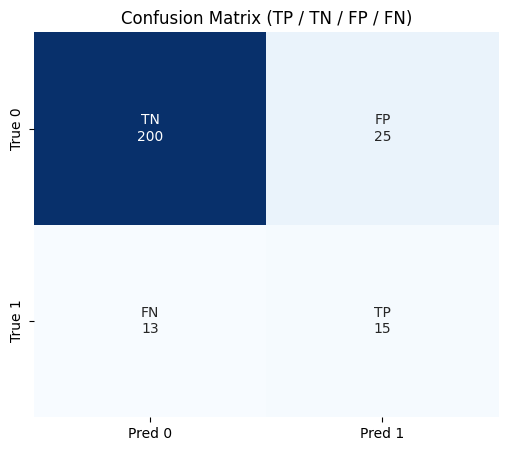

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = cat.predict(xte3)

cm = confusion_matrix(yte3, y_pred)

labels = ["TN", "FP", "FN", "TP"]
cm_labels = [f"{label}\n{value}" for label, value in zip(labels, cm.ravel())]
cm_reshaped = np.array(cm_labels).reshape(2, 2)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=cm_reshaped, fmt="", cmap="Blues", 
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"],
            cbar=False)

plt.title("Confusion Matrix (TP / TN / FP / FN)")
plt.show()

In [335]:
probs = cat.predict_proba(xte3)[:,1]
best_t = 0
best_f2 = 0
best_ra = 0
best_cm = 0
for t in np.linspace(0.01, 0.99, 300):
    preds = (probs > t).astype(int)
    f2 = fbeta_score(yte3, preds, beta=2, average='macro')
    r_a = roc_auc_score(yte3, preds, average='macro')
    cm = confusion_matrix(yte3, preds)
    if f2 > best_f2:
        best_f2 = f2
        best_t = t
        best_ra = r_a
        best_cm = cm
print(best_cm)
best_t, best_f2, best_ra

[[187  38]
 [  7  21]]


(0.3869230769230769, 0.7343484396548959, 0.7905555555555556)

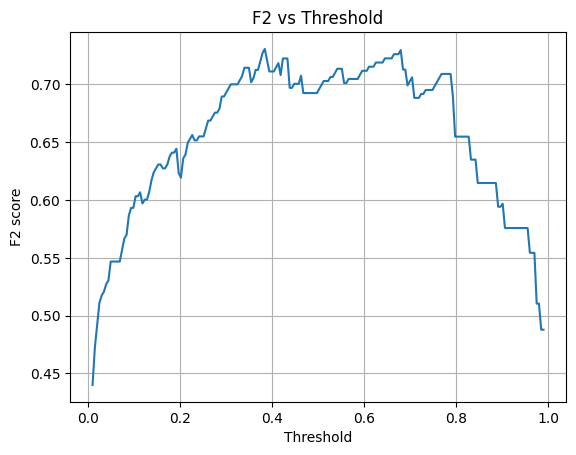

In [336]:
import matplotlib.pyplot as plt

ths = np.linspace(0.01, 0.99, 200)
scores = [fbeta_score(yte3, probs > t, beta=2, average='macro') for t in ths]

plt.plot(ths, scores)
plt.xlabel("Threshold")
plt.ylabel("F2 score")
plt.title("F2 vs Threshold")
plt.grid(True)
plt.show()

In [337]:
probs = cat.predict_proba(xte3)[:,1]
preds = (probs > 0.4).astype(int)
fbeta_score(yte3, preds, beta=2, average='macro')
confusion_matrix(yte3, preds)

array([[188,  37],
       [  9,  19]])

In [ ]:
class FrozenBertForTickets(nn.Module):
    def __init__(self, model_name, class_weights):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.encoder.requires_grad_(False)

        hidden = self.encoder.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Linear(hidden // 2, 2)
        )

        self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        mask = attention_mask.unsqueeze(-1)
        emb = (out.last_hidden_state * mask).sum(1) / mask.sum(1)

        logits = self.classifier(emb)

        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return loss, logits

        return logits

model_name = "./ruroberta_tickets_mlm_50000"
tokenizer = AutoTokenizer.from_pretrained(model_name, legacy_format=True, use_fast=False)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

device = "mps"

class_weights = torch.tensor([1.0, 10.0], dtype=torch.float32).to(device)
model_final = FrozenBertForTickets(model_name, class_weights).to(device)
from datasets import Dataset
tab_and_text = pd.concat([good, bads], ignore_index=True)
texts_final = tab_and_text["text"].tolist()
labels_final = tab_and_text["labels"].astype(int).tolist()

dataset_final = Dataset.from_dict({
    "text": texts_final,
    "label": labels_final
})
dataset_final = dataset_final.cast_column("label", ClassLabel(num_classes=2))

dataset_final = dataset_final.map(tokenize, batched=True)

dataset_final.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

training_args_final = TrainingArguments(
    output_dir="./bert_ticket_text_only",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-4,     
    num_train_epochs=2,     
    weight_decay=0.0,
    logging_steps=100,
    save_strategy="no",
    report_to="none",
    do_eval=False
)

trainer_final = Trainer(
    model=model_final,
    args=training_args_final,
    train_dataset=dataset_final
)

trainer_final.train()

text_only_ds = Dataset.from_dict({"text": tab_and_text["text"].tolist()})
text_only_ds = text_only_ds.map(tokenize, batched=True)
text_only_ds.set_format(type="torch", columns=["input_ids", "attention_mask"])
model.eval()
probs = []

loader_final = DataLoader(text_only_ds, batch_size=32)

with torch.no_grad():
    for batch in loader_final:
        logits = model_final(
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device)
        )
        pr = torch.softmax(logits, dim=1)[:,1]
        probs.extend(pr.cpu().numpy())

tab_and_text["p_bad_text"] = probs

cat_final = catboost.CatBoostClassifier(class_weights={0:1, 1:10})
cat_final.fit(tab_and_text.drop(['Incident_Number', 'labels', 'text'], axis=1), tab_and_text['labels'])

Some weights of RobertaModel were not initialized from the model checkpoint at ./ruroberta_tickets_mlm_50000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Casting the dataset:   0%|          | 0/2473 [00:00<?, ? examples/s]

Map:   0%|          | 0/2473 [00:00<?, ? examples/s]

  0%|          | 0/310 [00:00<?, ?it/s]

{'loss': 0.7058, 'grad_norm': 1.826987862586975, 'learning_rate': 0.00013548387096774193, 'epoch': 0.65}
{'loss': 0.6272, 'grad_norm': 1.2982629537582397, 'learning_rate': 7.096774193548388e-05, 'epoch': 1.29}
{'loss': 0.6131, 'grad_norm': 2.0845255851745605, 'learning_rate': 6.451612903225806e-06, 'epoch': 1.94}
{'train_runtime': 777.6583, 'train_samples_per_second': 6.36, 'train_steps_per_second': 0.399, 'train_loss': 0.6487333436166086, 'epoch': 2.0}


Map:   0%|          | 0/2473 [00:00<?, ? examples/s]

Learning rate set to 0.015165
0:	learn: 0.6853088	total: 2.63ms	remaining: 2.62s
1:	learn: 0.6804958	total: 4.64ms	remaining: 2.31s
2:	learn: 0.6761621	total: 6.45ms	remaining: 2.14s
3:	learn: 0.6699718	total: 9.09ms	remaining: 2.26s
4:	learn: 0.6637888	total: 10.8ms	remaining: 2.15s
5:	learn: 0.6584968	total: 13.3ms	remaining: 2.19s
6:	learn: 0.6496079	total: 14.9ms	remaining: 2.11s
7:	learn: 0.6418954	total: 16.3ms	remaining: 2.02s
8:	learn: 0.6366413	total: 17.8ms	remaining: 1.96s
9:	learn: 0.6303644	total: 19.1ms	remaining: 1.9s
10:	learn: 0.6259573	total: 20.2ms	remaining: 1.82s
11:	learn: 0.6205063	total: 21.3ms	remaining: 1.75s
12:	learn: 0.6141411	total: 22.3ms	remaining: 1.7s
13:	learn: 0.6095327	total: 23.5ms	remaining: 1.65s
14:	learn: 0.6038008	total: 24.6ms	remaining: 1.62s
15:	learn: 0.5997727	total: 25.7ms	remaining: 1.58s
16:	learn: 0.5951333	total: 26.8ms	remaining: 1.55s
17:	learn: 0.5886879	total: 27.9ms	remaining: 1.52s
18:	learn: 0.5843818	total: 28.9ms	remaining: 

In [409]:
torch.save(model_final.state_dict(), "text_only_head.pt")
tokenizer.save_pretrained("text_tokenizer")
cat_final.save_model("catboost_final.cbm")

In [338]:
tab_and_text.drop(['text', 'p_bad_text', 'Incident_Number'],axis=1).corr()

,Log_Count,Avg_Log_Interval,Max_Log_Interval,Status_Change_Count,Reassignments,Customer_Communications,Lifetime_hours,labels
Log_Count,1.000000,0.007181,0.227817,0.914251,0.807914,0.586233,0.393870,0.153201
Avg_Log_Interval,0.007181,1.000000,0.613049,0.003323,-0.008842,-0.016881,0.503042,-0.009956
Max_Log_Interval,0.227817,0.613049,1.000000,0.209934,0.149511,0.046433,0.873190,0.013180
Status_Change_Count,0.914251,0.003323,0.209934,1.000000,0.690560,0.619460,0.365439,0.141935
Reassignments,0.807914,-0.008842,0.149511,0.690560,1.000000,0.450754,0.262299,0.280780
Customer_Communications,0.586233,-0.016881,0.046433,0.619460,0.450754,1.000000,0.125975,0.043889
Lifetime_hours,0.393870,0.503042,0.873190,0.365439,0.262299,0.125975,1.000000,0.023210
labels,0.153201,-0.009956,0.013180,0.141935,0.280780,0.043889,0.023210,1.000000


In [339]:
pd.DataFrame(data=cat.feature_importances_.reshape(1, -1), columns=cat.feature_names_)

,Log_Count,Avg_Log_Interval,Max_Log_Interval,Status_Change_Count,Reassignments,Customer_Communications,Lifetime_hours,p_bad_text
0,11.505071,7.990656,9.810168,7.870206,31.152327,6.701136,8.378932,16.591505


In [402]:
torch.save(model.state_dict(), "text_only_head_split.pt")
tokenizer.save_pretrained("text_tokenizer_split")
cat.save_model("catboost_split.cbm")

In [446]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import catboost
from torch.utils.data import DataLoader, Dataset

device = "mps" if torch.cuda.is_available() else "cpu"

BASE_MODEL = "/Users/user/Downloads/ruroberta_tickets_mlm_50000"

tokenizer = AutoTokenizer.from_pretrained("text_tokenizer")

class TextOnlyClassifier(nn.Module):
    def __init__(self, model_name, hidden=64):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.encoder.requires_grad_(False)

        h = self.encoder.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(h, h // 2),
            nn.ReLU(),
            nn.Linear(h // 2, 2)
        )

    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        mask = attention_mask.unsqueeze(-1)
        emb = (out.last_hidden_state * mask).sum(1) / mask.sum(1)

        logits = self.classifier(emb)
        return logits

model = TextOnlyClassifier(BASE_MODEL).to(device)
model.load_state_dict(torch.load("text_only_head.pt", map_location=device), strict=False)
model.eval()

cat = catboost.CatBoostClassifier()
cat.load_model("catboost_split.cbm")

class ProdDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(
            self.texts[idx],
            max_length=512,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
        }

def predict_tickets(df: pd.DataFrame):

    text_ds = ProdDataset(df["text"].tolist())
    loader = DataLoader(text_ds, batch_size=32)

    text_probs = []

    with torch.no_grad():
        for batch in loader:
            logits = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
            )
            pr = torch.softmax(logits, dim=1)[:, 1]
            text_probs.extend(pr.cpu().numpy())

    df = df.copy()
    df["p_bad_text"] = text_probs

    X = df.drop(["text", "labels", "Incident_Number"], axis=1, errors="ignore")

    df["score"] = cat.predict_proba(X)[:, 1]
    return df.sort_values("score", ascending=False)

def preprocess_data(df):
    df['Worklog Date'] = pd.to_datetime(df['Worklog Date'])
    df['Detailed_Description'] = df['Detailed_Description'].apply(lambda x: x + '. ')

    df = (
        df
        .groupby(['Incident Title', 'Incident Notes', 'Incident_Number'])
        .agg(
            text=('Detailed_Description', 'sum'),
            Log_Count=('Worklog Date', 'count'),
            Avg_Log_Interval=('Worklog Date', lambda x: x.sort_values().diff().dt.total_seconds().mean() / 3600),
            Max_Log_Interval=('Worklog Date', lambda x: x.sort_values().diff().dt.total_seconds().max() / 3600),
            Status_Change_Count=('Work_Log_Type.1', lambda x: (x == 21003).sum()),
            Reassignments=('Work_Log_Type.1', lambda x: (x == 20000).sum()),
            Customer_Communications=('Work_Log_Type.1', lambda x: (x == 2000).sum()),
            Was_Reopen=('Work_Log_Type.1', lambda x: int((x == 21005).any())),
            Wrong_Assignment=(
                'Detailed_Description',
                lambda s: int(
                    s.astype(str)
                    .str.contains('Wrong Assignment', case=False, na=False)
                    .any()
                )
            ),
            # время жизни тикета
            First_Date=('Worklog Date', 'min'),
            Last_Date=('Worklog Date', 'max')
        )
        .reset_index()
    )

    # разница в часах
    df['Lifetime_hours'] = (df['Last_Date'] - df['First_Date']).dt.total_seconds() / 3600

    # текстовое поле
    df['text'] = df.apply(
        lambda x: 'Title ' + str(x['Incident Title']) +
                '. Notes ' + str(x['Incident Notes']) +
                '. Worklog ' + str(x['text']),
        axis=1
    )

    # чистим ненужное
    df.drop(['Incident Title', 'Incident Notes', 'First_Date', 'Last_Date', 'Was_Reopen', 'Wrong_Assignment'], axis=1, inplace=True)

    def preprocess_for_bert(text):
        text = str(text)
        text = re.sub(r'https?://\S+', ' <URL> ', text)
        text = re.sub(r'\S+@\S+', ' <EMAIL> ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df['text'] = df.text.apply(preprocess_for_bert)
    return df


Some weights of RobertaModel were not initialized from the model checkpoint at /Users/user/Downloads/ruroberta_tickets_mlm_50000 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/4p/ngvvj7355vvb84hsxlzc5xzh0000gn/T/ipykernel_34697/11252574.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are expli

In [375]:
not_in_good_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43291 entries, 117665 to 68418
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Incident_Number          43291 non-null  object 
 1   text                     43291 non-null  object 
 2   Log_Count                43291 non-null  int64  
 3   Avg_Log_Interval         43291 non-null  float64
 4   Max_Log_Interval         43291 non-null  float64
 5   Status_Change_Count      43291 non-null  int64  
 6   Reassignments            43291 non-null  int64  
 7   Customer_Communications  43291 non-null  int64  
 8   Lifetime_hours           43291 non-null  float64
 9   labels                   43291 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 3.6+ MB


In [377]:
df_val = pd.concat([not_in_good_val, bads_val]).sample(frac=1, random_state=42).reset_index(drop=True)
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43347 entries, 0 to 43346
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Incident_Number          43347 non-null  object 
 1   text                     43347 non-null  object 
 2   Log_Count                43347 non-null  int64  
 3   Avg_Log_Interval         43347 non-null  float64
 4   Max_Log_Interval         43347 non-null  float64
 5   Status_Change_Count      43347 non-null  int64  
 6   Reassignments            43347 non-null  int64  
 7   Customer_Communications  43347 non-null  int64  
 8   Lifetime_hours           43347 non-null  float64
 9   labels                   43347 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 3.3+ MB


In [381]:
df_scored = predict_tickets(df_val)

In [ ]:
# recall@433 = 2/56 ≈ 4%  TOP1%
df_scored.sort_values('score', ascending=False)[:433]['labels'].value_counts()

labels
0    431
1      2
Name: count, dtype: int64

In [ ]:
# recall@867 = 2/56 ≈ 4% TOP2%
df_scored.sort_values('score', ascending=False)[:867]['labels'].value_counts()

labels
0    865
1      2
Name: count, dtype: int64

In [ ]:
# recall@4335 = 33/56 ≈ 59% TOP10%
df_scored[:4335].sort_values('score', ascending=False)['labels'].value_counts()

labels
0    4302
1      33
Name: count, dtype: int64

In [425]:
# recall@8670 = 53/56 ≈ 95% TOP20%
df_scored[:8670].sort_values('score', ascending=False)['labels'].value_counts()

labels
0    8617
1      53
Name: count, dtype: int64

In [397]:
df_scored[10000:].sort_values('score', ascending=False)['labels'].value_counts()

labels
0    33344
1        3
Name: count, dtype: int64

Random baseline - 0.129%
Lift@k = Precision@k / Random baseline (эффективность модели)

recall@1% 	(2/56≈4%) 	Precision@1%  	0.46%   Lift@1%   	3.6x    
recall@2% 	(2/56≈4%) 	Precision@2%  	0.23%   Lift@2%   	1.8x    
recall@10%  (33/56≈59%) Precision@10%   0.76%   Lift@10%    5.9x    
recall@20%  (53/56≈95%) Precision@20%   0.61%   Lift@20%    4.7x    

Чтобы покрыть 95% всех плохих тикетов, достаточно просматривать 20% входящего потока вместо 100%.

Что мониторить дальше
	Score distribution drift
	median
	p95 / p99
	Количество тикетов в Top-K
	Стабильность признаков
	tabular stats
	token length

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
import matplotlib.pyplot as plt
import numpy as np

y_true = df_scored["labels"].values
proba = df_scored["score"].values

precision, recall, thresholds = precision_recall_curve(y_true, proba)

pr_auc_trapz = auc(recall, precision)                

print(f"Random Baseline: \t{56/43347:.4f}")
print(f"PR-AUC (trapz): \t{pr_auc_trapz:.4f}")
print(f'Roc-Auc: \t\t{roc_auc_score(y_true, proba):.4f}')

Random Baseline: 	0.0013
PR-AUC (trapz): 	0.0062
Roc-Auc: 		0.8949


In [ ]:
import numpy as np
import pandas as pd

def weekly_score_stats(df_scored: pd.DataFrame):
    """
    df_scored — датафрейм с колонкой 'score' и 'text' + табличные фичи.
    """

    scores = df_scored["score"].values
    n = len(scores)

    stats = {}

    # распределение скоров
    stats["n_tickets"]    = int(n)
    stats["score_median"] = float(np.median(scores))
    stats["score_mean"]   = float(np.mean(scores))
    stats["score_p95"]    = float(np.quantile(scores, 0.95))
    stats["score_p99"]    = float(np.quantile(scores, 0.99))

    # размер top-20%
    k = int(n * 0.2)
    stats["top_20_size"] = k

    # длина текста (прокси сложности тикета)
    token_len = df_scored["text"].astype(str).str.len()
    stats["text_len_mean"] = float(token_len.mean())
    stats["text_len_std"]  = float(token_len.std())
    stats["text_len_p95"]  = float(token_len.quantile(0.95))
    stats["text_len_p99"]  = float(token_len.quantile(0.99))

    # табличные фичи
    num_cols = [
        "Log_Count",
        "Avg_Log_Interval",
        "Max_Log_Interval",
        "Status_Change_Count",
        "Reassignments",
        "Customer_Communications",
        "Lifetime_hours",
    ]

    # оставим только те, что реально есть в датафрейме
    present_cols = [c for c in num_cols if c in df_scored.columns]

    if present_cols:
        tab_stats = df_scored[present_cols].agg(["mean", "std", "min", "max"])
        stats["tabular_stats"] = {
            col: {idx: float(tab_stats.loc[idx, col]) for idx in tab_stats.index}
            for col in tab_stats.columns
        }
    else:
        stats["tabular_stats"] = {}

    return stats

def round_stats(obj, ndigits=2):
    if isinstance(obj, float):
        return round(obj, ndigits)
    elif isinstance(obj, int):
        return obj
    elif isinstance(obj, dict):
        return {k: round_stats(v, ndigits) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [round_stats(v, ndigits) for v in obj]
    else:
        return obj

def weekly_score_df(stats: dict) -> pd.DataFrame:
    flat = {
        "n_tickets": stats["n_tickets"],
        "score_mean": stats["score_mean"],
        "score_median": stats["score_median"],
        "score_p95": stats["score_p95"],
        "score_p99": stats["score_p99"],
        "text_len_mean": stats["text_len_mean"],
        "text_len_p95": stats["text_len_p95"],
        "text_len_p99": stats.get("text_len_p99"),
    }

    # разворачиваем tabular_stats
    for feature, agg_dict in stats["tabular_stats"].items():
        for agg_name, value in agg_dict.items():
            flat[f"{feature}_{agg_name}"] = value

    return pd.DataFrame([flat])

In [447]:
df_week = pd.read_csv('/Users/user/Downloads/week_first.csv', sep=';')
df_week = preprocess_data(df_week)
df_week = df_week[df_week['text'].str.contains('[Resolved]',regex=False) | df_week['text'].str.contains('[Cancelled]',regex=False)]
df_week_scored = predict_tickets(df_week)

In [489]:
stats = weekly_score_stats(df_scored)
stats = round_stats(stats)
df_stats = weekly_score_df(stats)

In [490]:
df_stats

,n_tickets,score_mean,score_median,score_p95,score_p99,text_len_mean,text_len_p95,text_len_p99,Log_Count_mean,Log_Count_std,...,Reassignments_min,Reassignments_max,Customer_Communications_mean,Customer_Communications_std,Customer_Communications_min,Customer_Communications_max,Lifetime_hours_mean,Lifetime_hours_std,Lifetime_hours_min,Lifetime_hours_max
0,43347,0.2,0.04,0.87,0.98,2915.85,8731.8,44752.0,16.92,18.18,...,1.0,47.0,1.46,1.49,0.0,33.0,82.26,184.57,0.0,3045.33


In [ ]:
import json
import datetime
with open(f'stats_{str(datetime.datetime.now().date())}', "w", encoding="utf-8") as f:
    json.dump(stats, f, ensure_ascii=False, indent=2)

In [495]:
def predict_tickets_light(df: pd.DataFrame, cat, threshold=None):

    CAT_FEATURES = [
        "Log_Count",
        "Avg_Log_Interval",
        "Max_Log_Interval",
        "Status_Change_Count",
        "Reassignments",
        "Customer_Communications",
        "Lifetime_hours"
    ]

    X = df[CAT_FEATURES].astype(float)
    assert list(X.columns) == CAT_FEATURES


    proba = cat.predict_proba(X)[:, 1]

    df["score"] = proba

    return df
cat_light = catboost.CatBoostClassifier()
cat_light.load_model('catboost_light.cbm')
df_scored_light = predict_tickets_light(df_val, cat_light)

In [500]:
df_scored_light.sort_values('score', ascending=False)[:433]['labels'].value_counts()

labels
0    431
1      2
Name: count, dtype: int64

In [501]:
df_scored_light.sort_values('score', ascending=False)[:866]['labels'].value_counts()

labels
0    859
1      7
Name: count, dtype: int64

In [502]:
df_scored_light.sort_values('score', ascending=False)[:4335]['labels'].value_counts()

labels
0    4308
1      27
Name: count, dtype: int64

In [503]:
df_scored_light.sort_values('score', ascending=False)[:8665]['labels'].value_counts()

labels
0    8625
1      40
Name: count, dtype: int64

In [508]:
df_scored_light.sort_values('score', ascending=False)[:8665*2]['labels'].value_counts()

labels
0    17277
1       53
Name: count, dtype: int64

Random baseline - 0.129%
Lift@k = Precision@k / Random baseline (эффективность модели)

recall@1% 	(2/56≈4%) 	Precision@1%  	0.46%   Lift@1%   	3.6x    
recall@2% 	(7/56≈13%) 	Precision@2%  	0.81%   Lift@2%   	6.3x    
recall@10%  (27/56≈48%) Precision@10%   0.62%   Lift@10%    4.8x    
recall@20%  (40/56≈71%) Precision@20%   0.46%   Lift@20%    3.6x    
recall@40%  (53/56≈95%) Precision@40%   0.31%   Lift@40%    2.4x    

Чтобы покрыть 95% всех плохих тикетов, достаточно просматривать 40% входящего потока вместо 100%.

In [342]:
df_new = pd.concat([good, bads])
df_new.to_csv('good+bads.csv')


In [493]:
cat_light = catboost.CatBoostClassifier()
cat_light.load_model('catboost_light.cbm')
df_new11 = df_new.copy()
#df_new11['p_bad_text'] = 0
cat_light.predict(df_new11.drop(['Incident_Number', 'text', 'labels'], axis=1))

array([0, 0, 0, ..., 1, 1, 1])

In [343]:
preds, proba, xx = predict_tickets(df_new.sample(50), threshold=None)
sum(preds)/len(preds)

0.16

In [348]:
df_ = pd.read_csv('week_first.csv', sep=';')
df_ = preprocess_data(df_)[:100]
df_ = df_[df_['text'].str.contains('[Resolved]',regex=False)| df_['text'].str.contains('[Cancelled]',regex=False)]

In [349]:
preds, proba, xx = predict_tickets(df_, threshold=None)
sum(preds)/len(preds)

0.5128205128205128

In [426]:
#попробем catboost просто на табличках
xtr31,xte31,ytr31,yte31 = train_test_split(tab_and_text.drop(['p_bad_text', 'Incident_Number', 'labels', 'text'], axis=1), tab_and_text['labels'], test_size=.1, shuffle=True, stratify=tab_and_text['labels'], random_state=42)
cat1 = catboost.CatBoostClassifier(class_weights={0:1, 1:10})
cat1.fit(xtr31,ytr31)
print(fbeta_score(yte31, cat1.predict(xte31), beta=2, average='macro'))
print(roc_auc_score(yte31, cat1.predict(xte31), average='macro'))
confusion_matrix(yte31, cat1.predict(xte31))

Learning rate set to 0.014496
0:	learn: 0.6846048	total: 1.7ms	remaining: 1.7s
1:	learn: 0.6796029	total: 2.79ms	remaining: 1.39s
2:	learn: 0.6746234	total: 3.78ms	remaining: 1.26s
3:	learn: 0.6675320	total: 4.91ms	remaining: 1.22s
4:	learn: 0.6604669	total: 6.17ms	remaining: 1.23s
5:	learn: 0.6536505	total: 7.18ms	remaining: 1.19s
6:	learn: 0.6469551	total: 8.18ms	remaining: 1.16s
7:	learn: 0.6428066	total: 10ms	remaining: 1.25s
8:	learn: 0.6379626	total: 13.3ms	remaining: 1.46s
9:	learn: 0.6327580	total: 16.4ms	remaining: 1.63s
10:	learn: 0.6288895	total: 18.8ms	remaining: 1.69s
11:	learn: 0.6228866	total: 21.3ms	remaining: 1.75s
12:	learn: 0.6192413	total: 23.5ms	remaining: 1.78s
13:	learn: 0.6130007	total: 26.4ms	remaining: 1.86s
14:	learn: 0.6103062	total: 28.6ms	remaining: 1.88s
15:	learn: 0.6075088	total: 32.8ms	remaining: 2.02s
16:	learn: 0.6024174	total: 40.8ms	remaining: 2.36s
17:	learn: 0.5972822	total: 42ms	remaining: 2.29s
18:	learn: 0.5940803	total: 43.1ms	remaining: 2.23

array([[202,  23],
       [ 10,  13]])